In [1]:
using OrdinaryDiffEq
using Plots
using Random
using LaTeXStrings

rng = Xoshiro(14588); # set random number generator seed

Let's study the parameter identification problem of the following electric circuit which is fed by a constant voltage source. 

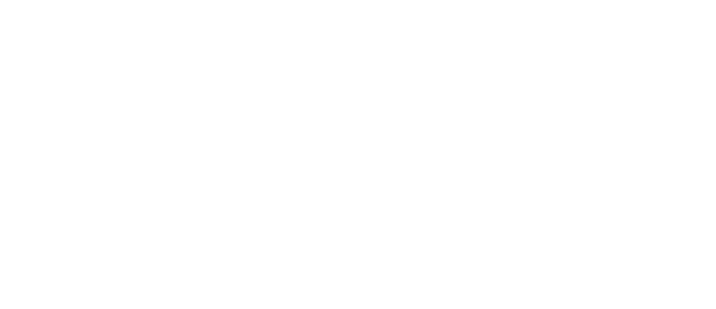

We will observe the circuit response starting from zero initial condition, however, for the data-driven model identification we can only utilize the measured current $i_1(t)$ at the circuit input while we will consider no further measurements within the circuit.

In [2]:
# Define parameter values of the circuit
R1 = 0.5;
R2 = 2.0;
R3 = 1.0;
L1 = 10e-3;
L2 = 50e-3;
C  = 500e-6;
v = 10.0; # input voltage

The circuit can be modeled as a set of first-order ODEs:
$$
\frac{\mathrm{d}}{\mathrm{d}t}\begin{bmatrix}i_1(t) \\ i_2(t) \\ v_\mathrm{C}(t)\end{bmatrix}=\frac{\mathrm{d}}{\mathrm{d}t}x(t) = \begin{bmatrix}-(R_1+R_2)/L_1 & R_3/L_1 &  -1/L_1 \\ R_3/L_2 & -(R_2+R_3)/L_2 & 1/L_2\\ 1/C & -1/C & 0\end{bmatrix}\begin{bmatrix}i_1(t) \\ i_2(t) \\ v_\mathrm{C}(t)\end{bmatrix} + \begin{bmatrix}1/L_1 \\ 0 \\ 0\end{bmatrix}v(t)
$$ 

Here, $i_1(t)$ and $i_2(t)$ are the inductors' currents and $v_\mathrm{C}(t)$ is the capacitor's voltage while $v(t)$ is the constant and scalar input voltage. The according ODE function in Julia is:

In [3]:
# Build circuit ODE model
function circuit!(dx, x, p, t)
    dx[1] = (-(R1+R2)*x[1] + R3*x[2] - x[3] + v) / L1
    dx[2] = (R3*x[1] - (R3+R2)*x[2] + x[3]) / L2
    dx[3] = (x[1] - x[2]) / C
end

circuit! (generic function with 1 method)

In [4]:
# initial conditions
x0 = [0.0, 0.0, 0.0];

#time span
tspan = (0.0, 0.1);

Next, we generate some ground truth data including measurement noise:

In [5]:
#define ODE problem
prob = ODEProblem(circuit!, x0, tspan)

#solve problem
sol = solve(prob, Tsit5(), saveat=0.0001)

# add noise to measured values
t, x = sol.t, sol.u # get time and state vector
N = length(t)
σ = 0.05; # standard deviation of measurement noise
y = reduce(hcat,x) + σ*randn(3,N); # add noise to state vector

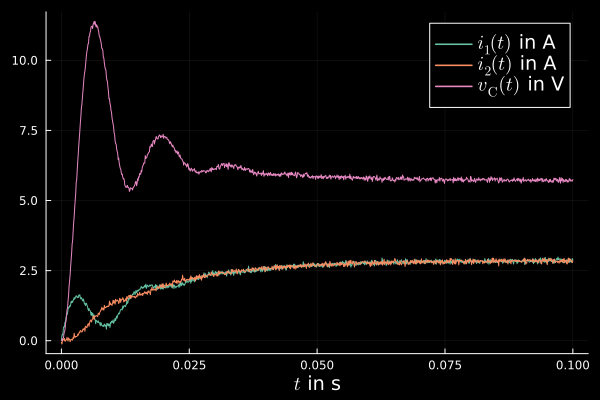

In [6]:
# plot noisy states
plot(t, y[1,:], label=L"$i_1(t)$ in A",
background_color="#000000",
grid=true, palette = :Set2_5, linecolor=1, legendfontsize = 13)
plot!(t, y[2,:], label=L"$i_2(t)$ in A", linecolor=2)
plot!(t, y[3,:], label=L"$v_\mathrm{C}(t)$ in V", linecolor=4)
xlabel!(L"$t$ in s", xguidefontsize=13)

Next, we define a training model with unknown parameters $w$:

In [7]:
function circuit_train!(dx,x,w,t)
    dx[1] = (-(w[1]+w[2])*x[1] + w[3]*x[2] - x[3] + 10) / w[4]
    dx[2] = (w[3]*x[1] - (w[3]+w[2])*x[2] + x[3]) / w[5]
    dx[3] = (x[1] - x[2]) / w[6]
    nothing
end;

# initial parameter guess (simply ones as an arbitrary initial choice)
w0 = ones(6,1);

The cost function is the squared error between the measured and modeled input current.

In [8]:
prob = ODEProblem(circuit_train!, x0, tspan, w0);
function costs(w, p)
    y = p[1]
    f = p[2]
    newprob = remake(f; p = w) # create an updated ODE problem with new parameters
    sol = solve(newprob,Tsit5(), saveat=0.0001)
    x = reduce(hcat,sol.u)    
    return sum(abs2.(y[1,:] - x[1,:])) # return the sum of squared errors (but only for the first state which is the only one we have measurements for)
end;

Further, we define the (hyper-)parameter $p$ as a tuple including both the ODE problem definition and the measurements.

In [9]:
_p = (y, prob);

In a first attempt, we use the [Optimization.jl](https://docs.sciml.ai/Optimization/stable/) toolbox with an underlying Newton solver via the Optim.jl package to solve the parameter identification problem. 

In [10]:
using Optimization, ForwardDiff, OptimizationOptimJL

In [11]:
optf = OptimizationFunction(costs, Optimization.AutoForwardDiff()); # create an optimization function
optprob = OptimizationProblem(optf, w0, _p); # create an optimization problem


In [12]:
# try catch on solve optimization error with Newton method
try
    optsol = solve(optprob, Optim.Newton()) # solve the optimization problem
catch
    println("Optimization failed")
end

Optimization failed


┌ Warning: dt(1.3877787807814457e-17) <= dtmin(1.3877787807814457e-17) at t=0.09502549781676109, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Oliver\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:599


As we can observe, the optimization problem failed. This is caused by evaluating a (numerically) unstable set of parameter candidates during the Newton iterations and their cost function calls which aborts the optimization. 

To overcome this issue, we can try to incorporate additional pre-knowledge as optimization constraints limiting the optimization space. We reformulate the optimization functions and incoporate lower and upper box constraints, that is, $$ \underline{w}\leq w \leq \bar{w}$$ with $\underline{w}$ being a vector holding the lower bounds and $\bar{w}$ being a vector representing the upper bounds. Based on general engineering pre-knowledge we know that none of the circuit parameters can have negative values and we can also define a reasonable upper bound from experience.

In [23]:
probopt_box = OptimizationProblem(optf, w0, _p, lb = ones(6)*10^-6, ub = ones(6)*10); # create a modified optimization problem

In [24]:
optsol_box = solve(probopt_box, Optim.LBFGS()); # Utilize the L-BFGS algorithm instead of Newton as the latter is not able to handle the box constraints
w_box = optsol_box.u; # get the found parameters

Apparently, the box constraints have helped to prevent (numerically) unstable parameters sets and the optimization algorithm has converged to a solution. Let’s see how the optimized parameters compare to the true ones:

In [25]:
#print true parameters vs. estimated parameters
println("True parameters: ", [R1, R2, R3, L1, L2, C])
println("Estimated parameters: ", round.(w_box, digits=5))

True parameters: [0.5, 2.0, 1.0, 0.01, 0.05, 0.0005]
Estimated parameters: [10.0; 1.74747; 10.0; 0.00712; 0.08264; 0.0195;;]


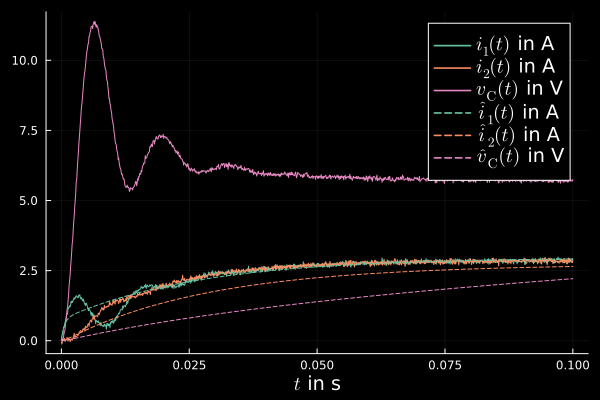

In [26]:
# Calculate system response based on the found parameters
newprob = remake(prob; p = w_box) # create an updated ODE problem with new parameters
sol_box = solve(newprob,Tsit5(), saveat=0.0001)
x_hat_box = reduce(hcat,sol_box.u)

# plot x_box vs. measurements
plot(t, y[1,:], label=L"$i_1(t)$ in A",
background_color="#000000",
grid=true, palette = :Set2_5, linecolor=1, legendfontsize = 13)
plot!(t, y[2,:], label=L"$i_2(t)$ in A", linecolor=2)
plot!(t, y[3,:], label=L"$v_\mathrm{C}(t)$ in V", linecolor=4)
xlabel!(L"$t$ in s", xguidefontsize=13)
# plot x_hat_box as dashed lines
plot!(t, x_hat_box[1,:], label=L"$\hat{i}_1(t)$ in A", linecolor=1, linestyle=:dash)
plot!(t, x_hat_box[2,:], label=L"$\hat{i}_2(t)$ in A", linecolor=2, linestyle=:dash)
plot!(t, x_hat_box[3,:], label=L"$\hat{v}_\mathrm{C}(t)$ in V", linecolor=4, linestyle=:dash)

Obviously, the estimated and measured current $i_1(t)$ somehow fits together, however, both the estimated parameters and the estimated other states clearly deviate from the ground truth. 

In order to further improve our identification approach, we can incorporate another constraint by performing a measurement in steady state where all current and voltages are constant. Based on that DC voltage/current measurement at the circuit's input, we can find: $$R_{\mathrm{dc}} = R_1 + R_2$$ which becomes another constraint to our optimization problem.

We start by defining an extended constraint function which first element will be handled as a equality constraint (based on the mentioned DC measurements) while the following elements of the `cons()` function represent the already known box constraints.

In [27]:
cons(res, x, p) = (res .= [x[1] + x[2]]);

We also modify our initial parameter guess such that the initial guesses of $R_1$ and $R_2$ fit to the equality constraint.

In [28]:
optf_cons = OptimizationFunction(costs, Optimization.AutoForwardDiff(); cons = cons) # create an optimization function including a constraint fct
probopt_cons = OptimizationProblem(optf_cons, [2.4; 0.1; 0.1; 0.1; 0.1; 0.1], _p, lcons = [2.5], ucons = [2.5], lb = ones(6)*10^-6, ub = ones(6)*10); # create a modified optimization problem

In [29]:
sol_cons = solve(probopt_cons, IPNewton()); # solve the optimization problem

In [30]:
w_cons = sol_cons.u; # get the found parameters

#print true parameters vs. estimated parameters
println("True parameters: ", [R1, R2, R3, L1, L2, C])
println("Estimated parameters: ", round.(w_cons, digits=5))

True parameters: [0.5, 2.0, 1.0, 0.01, 0.05, 0.0005]
Estimated parameters: [0.52751, 1.97249, 0.97721, 0.00993, 0.05047, 0.0005]


The insertion of prior knowledge and mapping it in a corresponding constraint of the optimization problem has accordingly led to an almost ideal estimation result, even though we have only used the input current $i_1(t)$ to calculate the cost function. This nice result is also visible in the following final plot.

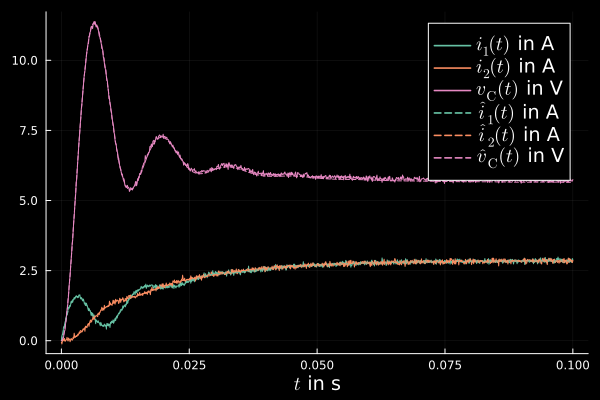

In [31]:
# Calculate system response based on the found parameters
newprob = remake(prob; p = w_cons) # create an updated ODE problem with new parameters
sol_cons = solve(newprob,Tsit5(), saveat=0.0001)
x_hat_cons = reduce(hcat,sol_cons.u)

# plot x_box vs. measurements
plot(t, y[1,:], label=L"$i_1(t)$ in A",
background_color="#000000",
grid=true, palette = :Set2_5, linecolor=1, legendfontsize = 13)
plot!(t, y[2,:], label=L"$i_2(t)$ in A", linecolor=2)
plot!(t, y[3,:], label=L"$v_\mathrm{C}(t)$ in V", linecolor=4)
xlabel!(L"$t$ in s", xguidefontsize=13)
# plot x_hat_box as dashed lines
plot!(t, x_hat_cons[1,:], label=L"$\hat{i}_1(t)$ in A", linecolor=1, linestyle=:dash)
plot!(t, x_hat_cons[2,:], label=L"$\hat{i}_2(t)$ in A", linecolor=2, linestyle=:dash)
plot!(t, x_hat_cons[3,:], label=L"$\hat{v}_\mathrm{C}(t)$ in V", linecolor=4, linestyle=:dash)